<a href="https://colab.research.google.com/github/nye0/SAM-Med2D/blob/main/predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Set-up
edit from [sam colab](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=MTeAdX_mHwAR)



If you're running this notebook locally using Jupyter, please clone `SAM-Med2D` into a directory named `SAM_Med2D`. Note that you do **not** need to install `segment_anything` in your local environment, as `SAM-Med2D` and `SAM` share function names that could lead to conflicts.

For Google Colab users: Set `using_colab=True` in the cell below before executing it. Although you can select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware Accelerator', this notebook is designed to run efficiently in a CPU environment as well.



# SAM-Med2D generates predicted object masks based on prompts.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import SimpleITK as sitk
from skimage.measure import label, regionprops
import torch
import torch.nn.functional as F

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.array([0, 1, 0, 0.5])
    else:
        color = np.array([1, 0, 0, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=1))


## Load SAM-Med2D model

In [3]:
from segment_anything import sam_model_registry
from segment_anything.predictor_sammed import SammedPredictor
from argparse import Namespace
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam-med2d_b.pth"
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load /volume/willy-dev/sota/SAM-Med2D/sam-med2d_b.pth


In [4]:
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 1024
args.encoder_adapter = False
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth"
model2 = sam_model_registry["vit_b"](args).to(device)
predictor2 = SammedPredictor(model2)

*******load /volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth


In [5]:
import hydra
from omegaconf import open_dict
from hydra import compose, initialize
from cutie.model.cutie import CUTIE
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.args_utils import get_dataset_cfg
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis

hydra.core.global_hydra.GlobalHydra.instance().clear()

with torch.inference_mode():
    initialize(version_base='1.3.2', config_path="Cutie/cutie/config", job_name="eval_config")
    cfg = compose(config_name="eval_config")

    with open_dict(cfg):
        cfg['weights'] = '/volume/willy-dev/sota/SAM-Med2D/Cutie/weights/cutie-base-mega.pth'

    data_cfg = get_dataset_cfg(cfg)

    # Load the network weights
    cutie = CUTIE(cfg).cuda().eval()
    model_weights = torch.load(cfg.weights)
    cutie.load_weights(model_weights)

processor = InferenceCore(cutie, cfg=cfg)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 76.5MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 59.3MB/s]


In [6]:
import glob
from tqdm import tqdm
import os

In [7]:
def get_slice(img, mask, index):
    
    slce = img[index].astype(float)
    slce -= slce.min()
    slce /= slce.max()
    slce *= 255
    slce = slce.astype(np.uint8)
    slce = np.stack([slce, slce, slce], axis=2)

    gt = mask[index]
    
    return np.copy(slce), np.copy(gt)

def get_predict(img, predictor, point=None, box=None):
    
    predictor.set_image(slce)
    
    if point is not None:
        input_point = np.array([point])
        input_label = np.array([1])
    else:
        input_point, input_label = None, None
    
    if box is not None:
        box = np.array([box])
    else:
        box = None
        
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box=box,
        multimask_output=True,
    )
    
    return masks[0]
    
    return predictor.model.image_encoder(x).flatten().unsqueeze(0)

In [8]:
def get_predict_mask(slce, init_center, predictor, last_slce=None, centroid=None):
    
    if last_slce is None:
        point = [init_center[2], init_center[1]]
    else:
        flow = cv2.calcOpticalFlowFarneback(last_slce[:,:,0], slce[:,:,0], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        point = [int(centroid[1]), int(centroid[0])] + flow[int(centroid[1]), int(centroid[0]), [1, 0]].astype(int)
        
    predict_mask = get_predict(slce, predictor, point = point)
    predict_mask = label(predict_mask.astype(int))
    
    target_pixel = predict_mask[point[1], point[0]]

    predict_mask[predict_mask != target_pixel] = 0
    predict_mask[predict_mask == target_pixel] = 1
    
    mask_prop = regionprops(predict_mask)[0]
    box, centroid = mask_prop.bbox, mask_prop.centroid

#     crop_img = slce[box[0]:box[2], box[1]:box[3]]
#     crop_encode = get_encode(crop_img, predictor)
    
    return predict_mask, slce, target_pixel, centroid, None

In [9]:
def visualize(slce, predict_mask, gt, box, fn):
    plt.figure(figsize=(5,5))
    plt.imshow(slce)
    show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_box(box, plt.gca())
    plt.axis('off')
    # plt.show()
    plt.savefig(f"output/{fn}")

In [10]:
def visualize(slce, predict_mask, gt, points, labels, fn):
    plt.figure(figsize=(5,5))
    plt.imshow(slce)
    # show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_points(points, labels, plt.gca())
    plt.axis('off')
    # plt.show()
    plt.savefig(f"output/{fn}")

In [14]:
from torchvision import ops

dices = []
dicesb = []

for j, di in tqdm(enumerate(glob.glob('/volume/open-dataset-ssd/ai99/gen_data/neuroma/*'))):
    
    try:
        img = sitk.ReadImage(f'{di}/axc.nii.gz')
        img = sitk.GetArrayFromImage(img)

        mask = sitk.ReadImage(f'{di}/seg.nii.gz')
        mask = sitk.GetArrayFromImage(mask)
    except:
        continue

    # if img.shape[0] < 100:
        # continue

    mask = label(mask)

    for i, prop in enumerate(regionprops(mask)):
        
        dices_tp = 0
        dices_pred = 0
        
        init_center = ((np.array(prop.bbox[:3]) + np.array(prop.bbox[3:]))/2).astype(int)

        z = init_center[0]
        slce, gt = get_slice(img, mask, z)
        
        gt[gt!=(i+1)] = 0
        gt[gt==(i+1)] = 1
        gt = F.interpolate(torch.tensor(gt).float().unsqueeze(0).unsqueeze(0), (512, 512))[0][0].int().numpy()
        
        predict_mask, slce, target_pixel, centroid, crop_encode = get_predict_mask(slce, init_center, predictor)
        
        frame_torch = image_to_torch(slce, device=device)
        mask_torch = index_numpy_to_one_hot_torch(predict_mask, 2).to(device)
        
        mask_torch = F.interpolate(mask_torch.unsqueeze(0), (512, 512))[0]
        init_mask_torch = torch.zeros(4, 512, 512).cuda()
        init_mask_torch[0] = mask_torch[1]
        
        init_frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]
        init_mask_torch = F.interpolate(init_mask_torch.unsqueeze(0), (480, 480))[0]
        
        with torch.inference_mode():
            processor.clear_memory()
            prediction = processor.step(init_frame_torch, init_mask_torch, idx_mask=False)

        prediction = torch_prob_to_numpy_mask(prediction)
        prediction = torch.tensor(prediction).float().unsqueeze(0).unsqueeze(0)
        prediction = F.interpolate(prediction, (512, 512))[0][0].cpu().numpy()

        # visualize(slce, prediction, gt, [[init_center[1], init_center[2]]], f"{os.path.basename(di)}_{z}.jpg")

        dices_tp += (gt*prediction).sum()
        dices_pred += prediction.sum()
        dice_ = 2 * (gt*prediction).sum()/(gt.sum() + prediction.sum())
        dices.append(dice_)
        
        z = init_center[0] + 1
        while z < img.shape[0]:
            
            slce, gt = get_slice(img, mask, z)
            
            gt[gt!=(i+1)] = 0
            gt[gt==(i+1)] = 1
            # gt = F.interpolate(torch.tensor(gt).float().unsqueeze(0).unsqueeze(0), (512, 512))[0][0].int().numpy()
            
            frame_torch = image_to_torch(slce, device=device)
            frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]
            
            with torch.inference_mode():
                prediction = processor.step(frame_torch)

            prediction = torch_prob_to_numpy_mask(prediction)

            prediction = torch.tensor(prediction).float().unsqueeze(0).unsqueeze(0)
            prediction = F.interpolate(prediction, (gt.shape[0], gt.shape[1]))[0]
            if prediction.sum() == 0: break

            box = ops.masks_to_boxes(prediction)[0]
            
            h, w = box[2] - box[0], box[3] - box[1]
            y, x = (box[2] + box[0])/2, (box[3] + box[1])/2

            pad = 1.1
            box = np.array([y-h/2*pad, x-w/2*pad, y+h/2*pad, x+w/2*pad])

            # raise Exception

            predictor2.set_image(slce)
            masks, scores, logits = predictor2.predict(
                box = box,
                multimask_output=False,
            )

            # visualize(slce, masks[0], gt, box, f"{os.path.basename(di)}_{z}.jpg")

            mask_torch = torch.zeros(4, masks.shape[1], masks.shape[2]).cuda()
            mask_torch[0] = torch.tensor(masks[0]).cuda()
            mask_torch = F.interpolate(mask_torch.unsqueeze(0), (480, 480))[0]

            with torch.inference_mode():
                # processor.clear_memory()
                prediction = processor.step(frame_torch, mask_torch, idx_mask=False)

            dices_tp += (gt*masks[0]).sum()
            dices_pred += masks[0].sum()
            dice_ = 2 * (gt*masks[0]).sum()/(gt.sum() + masks[0].sum())

            if gt.sum() > 0:
                dices.append(dice_)
            else:
                break
            
            z += 1
            
        with torch.inference_mode():
            processor.clear_memory()
            prediction = processor.step(init_frame_torch, init_mask_torch, idx_mask=False)
            
        z = init_center[0] - 1
        while z >= 0:
            slce, gt = get_slice(img, mask, z)
            
            gt[gt!=(i+1)] = 0
            gt[gt==(i+1)] = 1
            # gt = F.interpolate(torch.tensor(gt).float().unsqueeze(0).unsqueeze(0), (512, 512))[0][0].int().numpy()
            
            frame_torch = image_to_torch(slce, device=device)
            frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480))[0]
            
            with torch.inference_mode():
                prediction = processor.step(frame_torch)

            prediction = torch_prob_to_numpy_mask(prediction)

            prediction = torch.tensor(prediction).float().unsqueeze(0).unsqueeze(0)
            prediction = F.interpolate(prediction, (gt.shape[0], gt.shape[1]))[0]
            if prediction.sum() == 0: break

            box = ops.masks_to_boxes(prediction)[0]
            
            h, w = box[2] - box[0], box[3] - box[1]
            y, x = (box[2] + box[0])/2, (box[3] + box[1])/2
            
            pad = 1.1
            box = np.array([y-h/2*pad, x-w/2*pad, y+h/2*pad, x+w/2*pad])

            predictor2.set_image(slce)
            masks, scores, logits = predictor2.predict(
                box = box,
                multimask_output=False,
            )

            # visualize(slce, masks[0], gt, box, f"{os.path.basename(di)}_{z}.jpg")

            mask_torch = torch.zeros(4, masks.shape[1], masks.shape[2]).cuda()
            mask_torch[0] = torch.tensor(masks[0]).cuda()
            mask_torch = F.interpolate(mask_torch.unsqueeze(0), (480, 480))[0]

            with torch.inference_mode():
                # processor.clear_memory()
                prediction = processor.step(frame_torch, mask_torch, idx_mask=False)

            dices_tp += (gt*masks[0]).sum()
            dices_pred += masks[0].sum()
            dice_ = 2 * (gt*masks[0]).sum()/(gt.sum() + masks[0].sum())

            if gt.sum() > 0:
                dices.append(dice_)
            else:
                break
            
            z -= 1
    
        dicesb_ = 2*dices_tp/(dices_pred+prop.area * (512/mask.shape[-1])**3)
        
        dicesb.append(dicesb_)

        # raise Exception


134it [06:07,  2.74s/it]


In [12]:
dices = np.array(dices)
dicesb = np.array(dicesb)

0.8096056580110245


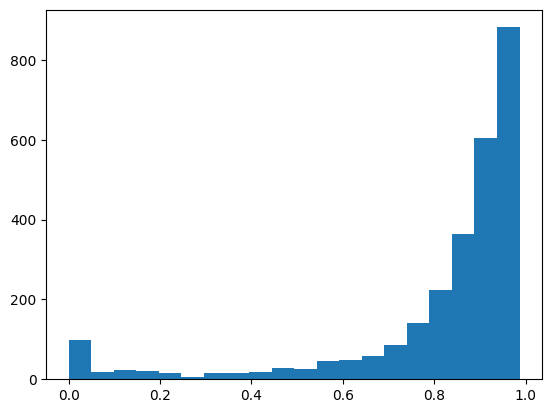

In [13]:
print(np.mean(dices))
plt.hist(dices,bins=20)
plt.show()